In [18]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Предобработка данных для модели

In [2]:
# загрузка сырых данных, первичная предобработка
def load_data():
    train_raw = pd.read_csv('./features.csv', index_col = 'match_id')

    # для начала необходимо удалить признаки связанные с исходом матча из train_raw
    train_raw.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'],
               axis = 1,
               inplace = True)

    train_raw = train_raw.fillna(0)

    # разделим тренировочный датасет на тренировочные данные и ответы
    X = train_raw
    y = train_raw['radiant_win'].to_frame()
    X.drop(['radiant_win'], axis=1, inplace=True)
    
    return X, y

In [3]:
# Нормализуем данные
X, y = load_data()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Подбор коэффициента регуляризации. Логистическая регрессия.

In [4]:
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [5]:
# определим фолды
kf = KFold(y.size, n_folds = 5, shuffle = True, random_state = 100)

C =  1e-05  Scores  [ 0.69152745  0.69604819  0.69771913  0.69275268  0.69767226] Time:  0:00:18.283733
C =  0.0001  Scores  [ 0.70863071  0.71095164  0.71349729  0.70821998  0.71532146] Time:  0:00:19.021519
C =  0.001  Scores  [ 0.71427066  0.71526043  0.71774199  0.71281341  0.72125087] Time:  0:00:20.957606
C =  0.01  Scores  [ 0.71449575  0.71540536  0.71756641  0.71288425  0.72170639] Time:  0:00:22.704202
C =  0.1  Scores  [ 0.71447166  0.71536882  0.71750102  0.71284082  0.72172155] Time:  0:00:23.383437
C =  1.0  Scores  [ 0.71446436  0.71536425  0.71749549  0.71283498  0.72172059] Time:  0:00:24.681767
C =  10.0  Scores  [ 0.7144641   0.71536354  0.7174944   0.71283446  0.72172094] Time:  0:00:23.370279
C =  100.0  Scores  [ 0.71446403  0.71536341  0.71749399  0.71283413  0.72172084] Time:  0:00:25.723343
C =  1000.0  Scores  [ 0.71446397  0.71536336  0.71749404  0.71283412  0.72172085] Time:  0:00:25.814883
C =  10000.0  Scores  [ 0.71446396  0.71536335  0.71749405  0.712834

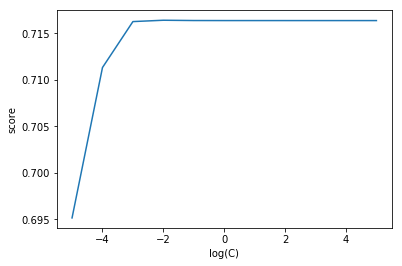

Max score:  0.716411631963
Best C:  0.01


In [6]:
# Вспомогательная функция для построения графиков
def plot_scores(c_power_range, scores):
    plt.plot(c_power_range, scores)
    plt.xlabel('log(C)')
    plt.ylabel('score')
    plt.show()

# Вспомогательная функция для тестирования модели с разным коэффициэнтов регуляризации
def test_linear_model(X, y):    
    c_scores = []
    c_power_range = range(-5, 6)
    c_range = [10.0 ** i for i in c_power_range]
    
    for c in c_range:
        start_t = datetime.datetime.now()
        model = LogisticRegression(C=c, random_state=100, n_jobs=-1)
        scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
        print('C = ', c, ' Scores ', scores, 'Time: ', datetime.datetime.now() - start_t)        
        c_scores.append(np.mean(scores))                    
        
    plot_scores(c_power_range, c_scores)
    print('Max score: ' , max(c_scores))
    print('Best C: ', c_range[c_scores.index(max(c_scores))])

# проверим модель
test_linear_model(X_scaled, y)    

# Выводы
* Наилучшее значение C = 0.01 при этом качество по ROC_AUC = ~0.71
<br>
* Качество сравнимо с градиентным бустингом на ~200-300 деревьях, время работы при этом значительно меньше

# 3. Логистическая регрессия, без категориальных признаков

C =  1e-05  Scores  [ 0.69301063  0.69476367  0.69562225  0.69507488  0.69702952] Time:  0:00:18.137618
C =  0.0001  Scores  [ 0.70936502  0.71042199  0.71168956  0.71168269  0.71353648] Time:  0:00:19.898171
C =  0.001  Scores  [ 0.71434804  0.71581532  0.71629769  0.7168852   0.71853275] Time:  0:00:20.576119
C =  0.01  Scores  [ 0.71450425  0.71622052  0.71627999  0.71725088  0.71854131] Time:  0:00:22.672053
C =  0.1  Scores  [ 0.71448206  0.71620992  0.71622569  0.71726917  0.71848436] Time:  0:00:23.365972
C =  1.0  Scores  [ 0.71447768  0.71620627  0.7162209   0.71727019  0.71847678] Time:  0:00:23.984102
C =  10.0  Scores  [ 0.71447669  0.71620645  0.71621968  0.71727123  0.71847581] Time:  0:00:22.502251
C =  100.0  Scores  [ 0.7144767   0.71620624  0.71621963  0.71727119  0.71847569] Time:  0:00:22.529282
C =  1000.0  Scores  [ 0.71447667  0.71620624  0.71621965  0.71727119  0.71847569] Time:  0:00:24.500038
C =  10000.0  Scores  [ 0.71447668  0.71620627  0.71621961  0.717271

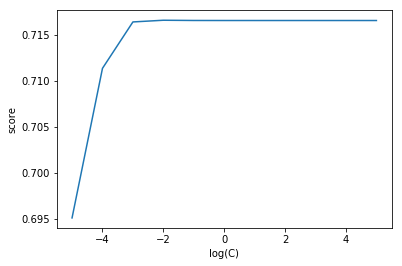

Max score:  0.716559388563
Best C:  0.01


In [7]:
# удалим категориальные признаки
X, y = load_data()

X.drop('lobby_type', axis = 1, inplace = True)
for n in range(1, 6):
    X.drop('r{}_hero'.format(n), axis = 1, inplace = True)
    X.drop('d{}_hero'.format(n), axis = 1, inplace = True)
  
# нормализуем
X_scaled = scaler.fit_transform(X)    
    
# проверим модель
kf = KFold(y.size, n_folds=5, shuffle=True, random_state=42)                
test_linear_model(X_scaled, y)

# Выводы
* Наилучшее значение C по прежнему = 0.01 при этом качество по ROC_AUC = ~0.71
<br>
* Удаление категориальных признаков не повлияло на качество. Модель, скорее всего, выкинула признаки из рассмотрения как маловажные

# 4. Логистическая регрессия, без категориальных признаков + мешок слов

C =  1e-05  Scores  [ 0.69734258  0.698844    0.6995673   0.69941962  0.70103117] Time:  0:00:18.526725
C =  0.0001  Scores  [ 0.7237361   0.72409993  0.72458163  0.72605192  0.72684832] Time:  0:00:19.779164
C =  0.001  Scores  [ 0.74477849  0.74668328  0.74397291  0.74889226  0.74736143] Time:  0:00:22.321429
C =  0.01  Scores  [ 0.74952425  0.7527421   0.74909059  0.75545962  0.75171022] Time:  0:00:25.835947
C =  0.1  Scores  [ 0.74946441  0.75310911  0.74936491  0.75604945  0.75156737] Time:  0:00:29.385418
C =  1.0  Scores  [ 0.74939012  0.75312646  0.74936582  0.75609138  0.75149749] Time:  0:00:29.398775
C =  10.0  Scores  [ 0.74938152  0.753125    0.74936249  0.75609488  0.75148833] Time:  0:00:29.828066
C =  100.0  Scores  [ 0.74938119  0.75312471  0.74936219  0.75609553  0.75148705] Time:  0:00:30.068816
C =  1000.0  Scores  [ 0.74938108  0.75312467  0.74936207  0.75609551  0.7514866 ] Time:  0:00:32.466564
C =  10000.0  Scores  [ 0.74938095  0.75312473  0.74936232  0.756095

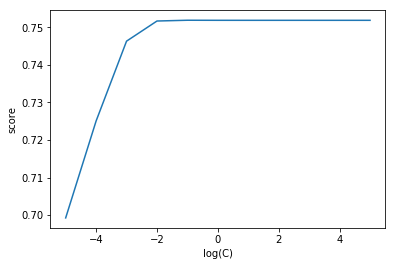

Max score:  0.751911050366
Best C:  0.1


In [8]:
# удалим категориальные признаки
X, y = load_data()        
X.drop('lobby_type', axis = 1, inplace = True)

# обработаем мешок слов из информации о распределении героев (112 героев)
X_pick = np.zeros((X.shape[0], 112))

for i, match_id in enumerate(X.index):
    for p in range(5):
        X_pick[i, X.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1            

X_hero = pd.DataFrame(X_pick, index=X.index)                

# нормализуем и обеденим с мешком
X_scaled = pd.DataFrame(scaler.fit_transform(X), index = X.index)
X_scaled = pd.concat([X_scaled, X_hero], axis=1)                
  
# проверим модель
kf = KFold(y.size, n_folds=5, shuffle=True, random_state=42)        
test_linear_model(X_scaled, y)

# Выводы
* Добавление мешка героев серьезно улучшает качество. При C = 0.01, качество по ROC_AUC = ~0.75
<br>
* Разреженная матрица подготовленная нами гораздо информативнее для модели

# Подготовим результаты для Kaggle

In [17]:
test_raw = pd.read_csv('./features_test.csv', index_col = 'match_id')

# удалим категориальные признаки
test_raw.drop('lobby_type', axis = 1, inplace = True)

test_raw = test_raw.fillna(0)

# обработаем мешок слов из информации о распределении героев (112 героев)
test_pick = np.zeros((test_raw.shape[0], 112))

for i, match_id in enumerate(test_raw.index):
    for p in range(5):
        test_pick[i, test_raw.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        test_pick[i, test_raw.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1            

test_hero = pd.DataFrame(test_pick, index=test_raw.index)                

# нормализуем и обеденим с мешком
test_scaled = pd.DataFrame(scaler.fit_transform(test_raw), index = test_raw.index)
test_scaled = pd.concat([test_scaled, test_hero], axis=1)                
  
# проверим модель
kf = KFold(test_scaled.size, n_folds=5, shuffle=True, random_state=100)        

model = LogisticRegression(C=0.1, random_state=100)
model.fit(X_scaled, y.values.ravel())
y_test = model.predict_proba(test_scaled)[:, 1]

# сохраним результаты
result = pd.DataFrame({'radiant_win': y_test}, index=test_scaled.index)
result.index.name = 'match_id'
result.to_csv('./kaggle_results.csv')

# Результаты Kaggle

Набрано очков: 0.75518
<br>
Место на момент отправки 577 (09-03-2018)